In [1]:
#from memory_profiler import profile
import fzMPI
from mpi4py import MPI

import yt
from yt.units import pc, kpc, second, Kelvin, gram, erg, cm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np

import compute_charge_dist as fz

%matplotlib inline

Loading the library to compute the charge distribution of dust grains.


In [2]:
# Define some constant parameters to be used.
mp      = 1.6726e-24  * gram # g
mH      = 1.6733e-24  * gram
mC      = 12.011*mH
#mu      = 1.2924
kb      = 1.3806e-16  *erg / Kelvin # erg K-1
GNewton = 6.6743e-8   * cm**3 / (gram * second**2 )# cm3 g-1 s-2
Msun    = 1.9884e33   * gram
#mm      = mu*mp

ppc = 3.0856776e18

# -------------------------------------------------------------
#              Create a lot of new derived fields
# -------------------------------------------------------------

# -------------------------------------------------------------
#              Create a lot of new derived fields
# -------------------------------------------------------------

# Create a derived field.
# Hydrogen number density
def numdensH(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    return nH

# Molecular Hydrogen number density
def numdensH2(field, data): 
    nH2 = data["dens"]*(data["ih2 "])/(1.4*mH)
    return nH2

# Carbon number density
def numdensC(field, data): 
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    return nC

# electron number density
def numdense(field, data): 
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    return ne

# Ionized hydrogen fraction
def xHp(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xHp = data["dens"]*data["ihp "]/(1.4*mH)
    xHp = xHp / nH
    return xHp

# Molecular hydrogen fraction
def xH2(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xH2 = data["dens"]*data["ih2 "]/(1.4*mH)
    xH2 = xH2 / nH
    return xH2

# Ionized carbon fraction
def xCp(field, data): 
    nC  = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    xCp = data["dens"]*data["icp "]/(1.4*mC) / nC
    return xCp

# electron fraction
def xe(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    xe = ne / (nH + nC)
    return xe

# electron fraction
#def GG(field, data): 
#    G = fz.get_G(data["cdto"], 1.68)
#    return G


yt.add_field('nH', function=numdensH,  units="1/cm**3", force_override=True)
yt.add_field('nH2',function=numdensH2, units="1/cm**3", force_override=True)
yt.add_field('nC', function=numdensC,  units="1/cm**3", force_override=True)
yt.add_field('ne', function=numdense,  units="1/cm**3", force_override=True)
yt.add_field('xHp', function=xHp,      units="dimensionless", force_override=True)
yt.add_field('xH2', function=xH2,      units="dimensionless", force_override=True)
yt.add_field('xCp', function=xCp,      units="dimensionless", force_override=True)
yt.add_field('xe', function=xe,        units="dimensionless", force_override=True)
#yt.add_field('G',  function=GG,        units="dimensionless", force_override=True)

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


In [3]:
fzMPI.print_to_logfile("Initializing clock.")

# Input variables.
data_dir   = "/home/jcibanezm/codes/run/Silcc/CF_Prabesh"
filename   = data_dir + "/NL99_R8_cf_hdf5_chk_0028"

pf = yt.load("%s"%(filename))

yt : [INFO     ] 2018-11-13 18:14:03,486 Particle file found: NL99_R8_cf_hdf5_chk_0028
yt : [INFO     ] 2018-11-13 18:14:03,494 integer runtime parameter checkpointfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-13 18:14:03,495 integer runtime parameter forcedplotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-13 18:14:03,496 integer runtime parameter nbegin overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-13 18:14:03,497 integer runtime parameter plotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-13 18:14:03,523 Parameters: current_time              = 5.68049127342e+14
yt : [INFO     ] 2018-11-13 18:14:03,523 Parameters: domain_dimensions         = [32  8  8]
yt : [INFO     ] 2018-11-13 18:14:03,524 Parameters: domain_left_edge          = [ -1.97478400e+20  -4.93696000e+19  -4.93696000e+19]
yt : [INFO     ] 2018-11-13 18:14:03,525 Parameters: domain_righ

Initializing clock.


In [4]:
c  = [0,0,0]
le = [-4.93696000e+19, -4.93696000e+19, -4.93696000e+19]
re = [ 4.93696000e+19,  4.93696000e+19,  4.93696000e+19]

box = pf.box(le, re)

In [5]:
ncells = len(box["nH"])

num_cells     = np.int(1.0e4)

In [6]:
min_dens = np.min(box["density"])
max_dens = np.max(box["density"])

min_nh   = np.min(box["nH"])
max_nh   = np.max(box["nH"])

min_temp = np.min(box["temperature"])
max_temp = np.max(box["temperature"])

min_ne = np.min(box["ne"])
max_ne = np.max(box["ne"])

min_xe = np.min(box["xe"])
max_xe = np.max(box["xe"])

min_Av = np.min(box["cdto"])
max_Av = np.max(box["cdto"])

In [7]:
np.random.seed(1)
#np.random.seed(2)

ncells = len(box["nH"])
n1     = np.int(ncells * 0.01)
#n5 = int(1.0e3)
rand_index = np.random.randint(0, ncells, n1)

# In[24]:
temp1= np.array(box["temp"][rand_index])
dd1  = np.array(box["dens"][rand_index])
nH1  = np.array(box["nH"]  [rand_index])
nH21 = np.array(box["nH2"] [rand_index])
nC1  = np.array(box["nC"]  [rand_index])
ne1  = np.array(box["ne"]  [rand_index])
xe1  = np.array(box["xe"]  [rand_index])
xHp1 = np.array(box["xHp"] [rand_index])
xH21 = np.array(box["xH2"] [rand_index])
xCp1 = np.array(box["xCp"] [rand_index])
Av1  = np.array(box["cdto"][rand_index])
fH2shield1 = np.array(box["cdh2"][rand_index])


In [8]:
np.random.seed(1)
#np.random.seed(2)

ncells = len(box["nH"])
n50     = np.int(ncells * 0.5)
#n5 = int(1.0e3)
rand_index50 = np.random.randint(0, ncells, n50)

# In[24]:
temp50= np.array(box["temp"][rand_index50])
dd50  = np.array(box["dens"][rand_index50])
nH50  = np.array(box["nH"]  [rand_index50])
nH250 = np.array(box["nH2"] [rand_index50])
nC50  = np.array(box["nC"]  [rand_index50])
ne50  = np.array(box["ne"]  [rand_index50])
xe50  = np.array(box["xe"]  [rand_index50])
xHp50 = np.array(box["xHp"] [rand_index50])
xH250 = np.array(box["xH2"] [rand_index50])
xCp50 = np.array(box["xCp"] [rand_index50])
Av50  = np.array(box["cdto"][rand_index50])
fH2shield50 = np.array(box["cdh2"][rand_index50])


In [9]:
import pickle
outfile = open('/home/jcibanezm/codes/DustAnalysis/Charge/PaperFigures_DustCharge/new_xe.pkl', 'rb')
new_xe = pickle.load(outfile)
#pickle.dump(xe_new1000, outfile)
outfile.close()

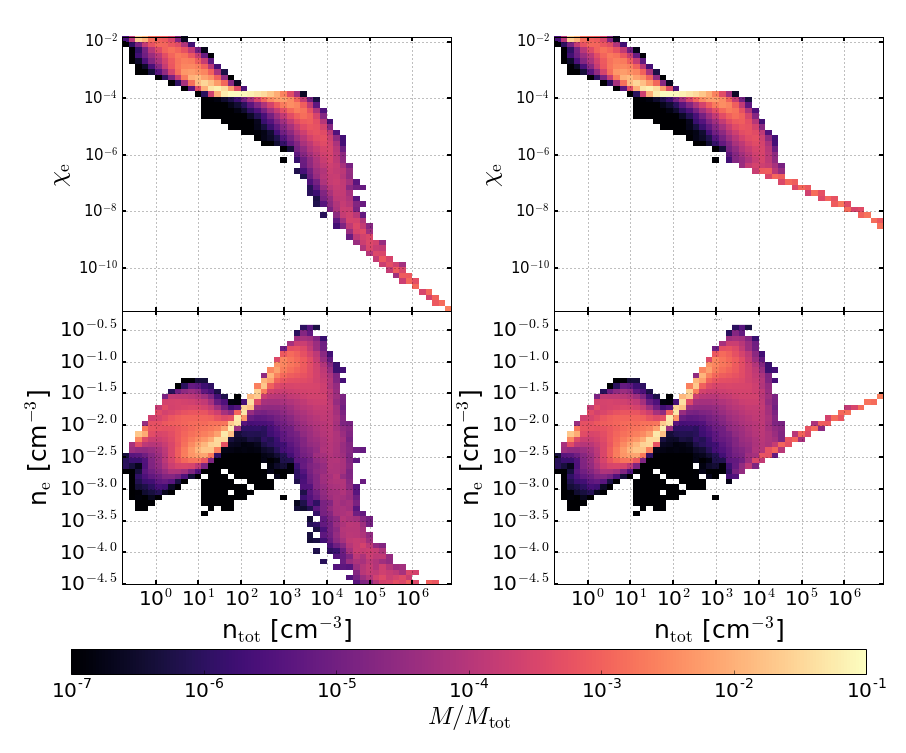

In [15]:
xsize = 12
ysize = 10

nfigs_x = 2
nfigs_y = 2

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.205
wpad = 0.115
w0   = 0.11

xs_panel = 0.76 / nfigs_x 
ys_panel = 0.76 / nfigs_y 

# Formatting tick labels in log scale.
def format_func(value, tick_number):
    return "10$^{%.1f}$"%value

# Formatting tick labels in log scale.
def format_func2(value, tick_number):
    return "10$^{%i}$"%value
############################################################################################################
############################               5 Angstroms             #######################################
############################################################################################################

ax = fig.add_axes([0, 0, 1, 1])

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

#ax.text(0.18, 0.955, "title?", fontsize=20, horizontalalignment='center')

plt.axis('off')

total_mass = np.sum(box["cell_mass"].in_units("Msun").value)

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0


ax = fig.add_axes([w0 + ii*xs_panel+ii*wpad, hpad + jj*ys_panel, xs_panel, ys_panel])

#H, xc, yc = np.histogram2d(np.log10(box["nH"]), np.log10(box["temp"]), weights=box["cell_mass"].in_units("Msun"), bins=50)
#H_norm = H / np.sum(box["cell_mass"].in_units("Msun").value)

cax = ax.hist2d(np.log10(box["nH"]), np.log10(box["nH"]*box["xe"]), bins=50, norm=LogNorm(), weights=box["cell_mass"].in_units("Msun")/total_mass, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.log10(min_ne), np.log10(max_ne)]]), vmin=1.0e-7, vmax=0.1)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=20, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=20, direction="in")

ax.grid("on")

ax.set_xlabel("n$_{\\mathrm{tot}}$ [cm$^{-3}$]", fontsize=25)
ax.set_ylabel("n$_{\\mathrm{e}}$ [cm$^{-3}$]", fontsize=25)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=20)

ax.set_ylim(-4.5, -0.2)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0


ax = fig.add_axes([wpad + ii*xs_panel+ii*wpad, hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(box["nH"]), np.log10(box["nH"]*new_xe), bins=50, norm=LogNorm(), weights=box["cell_mass"].in_units("Msun")/total_mass, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.log10(min_ne), np.log10(max_ne)]]), vmin=1.0e-7, vmax=0.1)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=20, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=20, direction="in")

ax.grid("on")

ax.set_xlabel("n$_{\\mathrm{tot}}$ [cm$^{-3}$]", fontsize=25)
ax.set_ylabel("n$_{\\mathrm{e}}$ [cm$^{-3}$]", fontsize=25)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=20)

ax.set_ylim(-4.5, -0.2)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 1


ax = fig.add_axes([w0 + ii*xs_panel+ii*wpad, hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(box["nH"]), np.log10(box["xe"]), bins=50, norm=LogNorm(), weights=box["cell_mass"].in_units("Msun")/total_mass, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.log10(min_xe), np.log10(max_xe)]]), vmin=1.0e-7, vmax=0.1)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=20, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=20, direction="in")

ax.grid("on")

ax.set_xlabel("log$_{10}$(n$_{\\mathrm{tot}}$) [cm$^{-3}$]", fontsize=0)
ax.set_ylabel("$\\chi_{\\mathrm{e}}$", fontsize=25)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=15)
ax.tick_params(axis='x', labelbottom='off')

#ax.set_ylim(-11, -0.2)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func2))

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 1


ax = fig.add_axes([wpad + ii*xs_panel+ii*wpad, hpad + jj*ys_panel, xs_panel, ys_panel])

ax.hist2d(np.log10(box["nH"]), np.log10(new_xe), bins=50, norm=LogNorm(), weights=box["cell_mass"].in_units("Msun")/total_mass, cmap="magma", range=([[np.log10(min_nh), np.log10(max_nh)],[np.log10(min_xe), np.log10(max_xe)]]), vmin=1.0e-7, vmax=0.1)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=20, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=20, direction="in")

ax.grid("on")

ax.set_xlabel("log$_{10}$(n$_{\\mathrm{tot}}$) [cm$^{-3}$]", fontsize=00)
ax.set_ylabel("$\\chi_{\\mathrm{e}}$", fontsize=25)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=15)
ax.tick_params(axis='x', labelbottom='off')

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func2))

# Add colorbar.

#cax[3] = cax[3]/np.sum(box["cell_mass"].in_units("Msun").value)

cbar_ax = fig.add_axes([0.051, 0.08, 0.92, 0.035])
cbar    = fig.colorbar(cax[3], cax=cbar_ax, orientation="horizontal")
#cbar    = fig.colorbar(cax, cax=cbar_ax, orientation="horizontal")

cbar.set_label("$M/M_{\mathrm{tot}}$", fontsize=25, labelpad=1)
cbar.ax.tick_params(labelsize=20)

fig.show()

fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/ChargeDist_Dust/Figures/Apendix/IonizationFraction_Comp.pdf", format="pdf")
#fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/ChargeDist_Dust/Figures/Apendix/newionfrac.pdf", format="pdf")